In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
from pathlib import Path 
import traceback
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt

from hyperbolicTSNE import Datasets
from hyperbolicTSNE import Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import HyperbolicKL, GaussianKL
from hyperbolicTSNE.util import find_last_embedding, opt_config, initialize_logger, write_data, store_visuals
from hyperbolicTSNE.data_loaders import load_mnist
from hyperbolicTSNE.hd_mat_ import hd_matrix
from hyperbolicTSNE.visualization import animate, plot_poincare

In [17]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots
grad_path = "temp/grad/"     # NOTE: We will manually calculate the gradients

seed = 42

# General settings 
dataset = Datasets.MNIST
num_points = [-1]
perplexities = [50]
correct_gradient = True                          # NOTE: Recompile with correct flag (GRAD_FIX flag)
exact = True                                     # Exact computation or BH estimation of gradient
pca_components = 0                               # Whether to use pca initialization of high dim. data or not
grad_scale_fix = True                            # Whether we multiply the gradient by the inverse metric tensor of hyperbolic space or not
                                                 # Note that the correct hyperoblic gradient has an inverse metric tensor factor
var = 1                                          # Variance for lower dim. gaussian distribution (NOTE: How to decide on var?)

# Simple experiment with no exaggeration
exaggeration_factor = 12
ex_iterations = 0
main_iterations = 1000

In [18]:
# Compute initial embedding in Poincare disk (PCA embedding)
cf = GaussianKL
X_embedded = initialization(
    n_samples=dataX.shape[0], 
    n_components=2,
    X=dataX,
    random_state=seed,
    method="random"
) 

# Initialize config and parameters
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 

log_path_cf = log_path + f"cf_{cf.class_str()}/correct_grad_{correct_gradient}/"
grad_path_grad = grad_path + f"cf_{cf.class_str()}/correct_grad_{correct_gradient}/"

opt_params, opt_conf = initialize_logger(opt_params, opt_conf, log_path_cf, grad_path_grad)
opt_params["cf_params"].update({"grad_fix" : correct_gradient})     # So the cost function knows which gradient to use
opt_params["cf_params"].update({"var" : var})

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.GaussianKL'>, 'learning_rate_ex': 0.0008333333333333334, 'learning_rate_main': 0.0008333333333333334, 'exaggeration': 12, 'exaggeration_its': 0, 'gradientDescent_its': 1000, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': True, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999, 'grad_scale_fix': True, 'grad_fix': True}


In [19]:
# Set up H-TSNE object 
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed",
    verbose=1, 
    opt_method=SequentialOptimizer,         # the optimizater we use
    opt_params=opt_params              # the parameters for the optimizers
    )

# Compute embedding:
try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
    
except ValueError:
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent: 0it [00:00, ?it/s]


Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: -0.01887 grad_norm: 8.32309e-08:  89%|████████▉ | 890/1000 [00:05<00:00, 177.66it/s]

3


Animation being saved to: results/gradient_vis_images/gradienttesting_cf_GaussianKL_correctgrad_True.gif


Animating:   0%|          | 0/179 [00:00<?, ?it/s]f:\School\TU_DELFT_THESIS\hyperbolic-tsne\hyperbolicTSNE\visualization.py:322: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=179.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
MovieWriter ffmpeg unavailable; using Pillow instead.
Animating: : 182it [00:12, 14.28it/s]                       


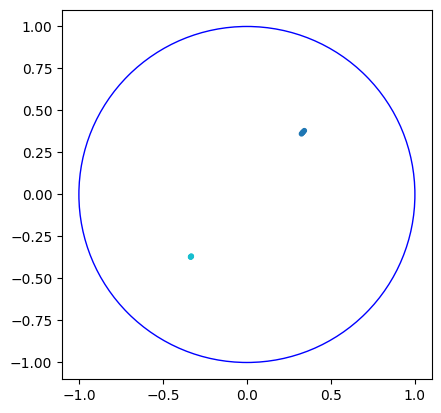

In [20]:
 # Store visuals
save_folder = "results/gradient_vis_images"
file_name = f"{save_folder}/gradienttesting_cf_{cf.class_str()}_correctgrad_{correct_gradient}"

# Create folder if it doesn't exist
path = Path(save_folder)
path.mkdir(parents=True, exist_ok=True)

fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.savefig(f"{file_name}.png")

# Save animation
animate(opt_params["logging_dict"], dataLabels, f"{file_name}.gif", fast=True, plot_ee=True)

In [21]:
from gradient_experiments import GradientComparisons
from pathlib import Path

embedding_folder_path = f"temp/poincare/cf_{cf.class_str()}/correct_grad_True"              # Where our embeddings are 
output_folder_path = f"results/gradient_comparisons/cf_{cf.class_str()}"                    # Where to store our results
V = V                                                                                       # High dim. affinity matrix, precomputed

# For each type of gradient, calculate the gradients and store the results
for correct_gradient in [True, False]:
    # Initialize config and parameters
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

    opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
    opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 
    opt_params["cf_params"].update({"grad_fix" : correct_gradient})         # So the cost function knows which gradient to use
    opt_params["cf_params"].update({"var" : 1})                             # Variance needed for GaussianKL cost function
    params = opt_params["cf_config_params"] | opt_params["cf_params"]       # Params to initialize cf

    key = f"linear_hierarchical_data_nclusters:{n_clusters}_ndata:{n_samples}"
    cf = GaussianKL(n_components=2, other_params=params)                  
    
    # Run experiment
    Experiment_Gradients = GradientComparisons(embedding_folder_path, cf, key)  
    Experiment_Gradients.compute_gradients(V, correct_gradient, output_folder_path, var=var)

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
